In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import sys

from pathlib import Path
from IPython.display import display, HTML
from scipy.signal import stft
from statsmodels.formula.api import ols
import statsmodels.api as sm

# Add the root directory of the project to the Python path of the notebook's session
project_root = Path.cwd().parent  # Assuming the notebook is in the "notebooks" folder
sys.path.append(str(project_root))

# Import the DataExtractor class
from src.DataExtraction.DataExtractor import DataExtractor
from src.Preprocessing.utils import eeg_slices

## Load Data

In this EDA, only data for Dog1 and Dog2 is analyzed for simplicity

In [2]:
data_extractor = DataExtractor(data_directory="data", test_labels_file="TestLabels.csv")

data_extractor.load_data(dog_ids=["Dog_1", "Dog_2"])

Loaded 3935 test labels from c:\Users\User\Documents\Python Projects\SeizureSen\data\TestLabels.csv
Loaded data for 2 dog(s)
  - Interictal segments: 980
  - Preictal segments: 66
  - Test segments: 1502


In [15]:
interictal_training = data_extractor.data["interictal"]
preictal_training = data_extractor.data["preictal"]
test_data = data_extractor.data["test"]

In [16]:
test_labels = [label for segment, label in data_extractor.test_labels.items() if "Dog_1" in segment or "Dog_2" in segment]

## Dataset Composition

In [17]:
# Basic characteristics of the 10-min iEEG segments for dog 1

sample_interictal_training = interictal_training[0]
sample_preictal_training = preictal_training[0]
sample_test_data = test_data[0]

metadata_samples = [sample_preictal_training, sample_interictal_training, sample_test_data]
samples_type = ["Preictal", "Interictal", "Test"]

metadata_dict = {"Sampling Frequency (Hz)": [], "Duration of each Segment (s)": [], "Number of Channels": []}
for sample in metadata_samples:
    metadata_dict["Sampling Frequency (Hz)"].append(round(sample["sampling_frequency"], 2))
    metadata_dict["Duration of each Segment (s)"].append(sample["data_length"])
    metadata_dict["Number of Channels"].append(len(sample["channels"]))

metadata_df = pd.DataFrame(metadata_dict, index=[samples_type])
metadata_df

Sampling Frequency (Hz)  Duration of each Segment (s)  \
Preictal                     399.61                           600   
Interictal                   399.61                           600   
Test                         399.61                           600   

            Number of Channels  
Preictal                    16  
Interictal                  16  
Test                        16

### Training Set

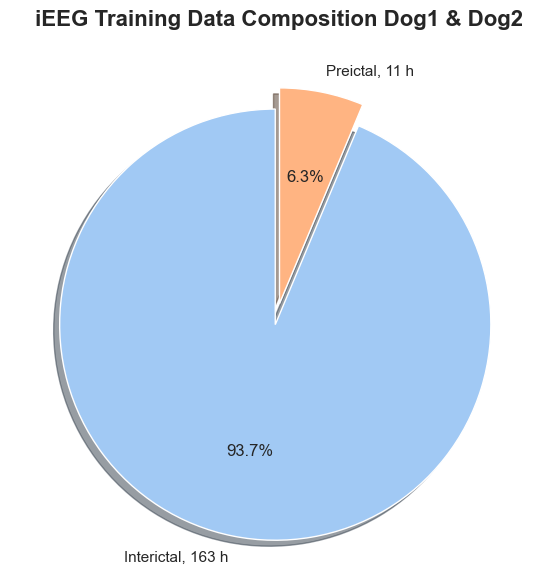

In [18]:
total_time_preictal = sum([int(preictal_segment["data_length"]) for preictal_segment in preictal_training])
total_time_interictal = sum([int(interictal_segment["data_length"]) for interictal_segment in interictal_training])

# Convert times in seconds to hours
preictal_hours = total_time_preictal / 3600 
interictal_hours = total_time_interictal / 3600

# Set Seaborn theme
sns.set_theme(style="whitegrid")

# Data for the pie chart
labels = ['Interictal', 'Preictal']
times = [total_time_interictal, total_time_preictal]
hours = [interictal_hours, preictal_hours]

# Combine labels with percentages and times in hours
label_with_details = [
    f"{label}, {time:.0f} h" 
    for label, time in zip(labels, hours)
]

# Plot the pie chart
plt.figure(figsize=(7, 7))
plt.pie(
    times,
    labels=label_with_details,
    autopct='%1.1f%%',
    startangle=90,
    colors=sns.color_palette("pastel")[:len(labels)],  # Use Seaborn pastel palette
    explode=(0.1, 0),  # Slightly separate the preictal sector
    shadow=True
)

plt.title('iEEG Training Data Composition Dog1 & Dog2', fontsize=16, weight='bold')
plt.show()

### Test set

In [19]:
test_segment_duration = test_data[0]["data_length"]

test_labels_s = pd.Series(test_labels)

test_set_composition_s = test_labels_s.value_counts()
test_set_composition_s.index = ["interictal", "preictal"]
test_set_composition_s

interictal    1388
preictal       114
Name: count, dtype: int64

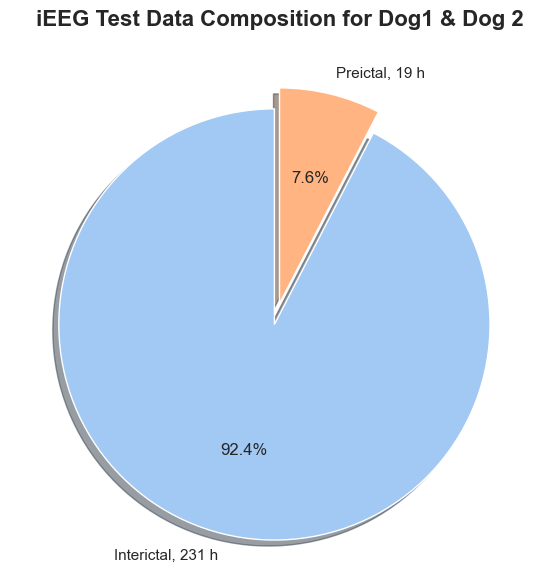

In [20]:
times_test_set_s = test_set_composition_s * test_segment_duration / 3600

[total_time_test_interictal, total_time_test_preictal] = times_test_set_s.tolist()

# Data for the pie chart
labels = ['Interictal', 'Preictal']
times_test_set = [total_time_test_interictal, total_time_test_preictal]

# Combine labels with percentages and times in hours
label_with_details = [
    f"{label}, {time:.0f} h" 
    for label, time in zip(labels, times_test_set)
]

# Plot the pie chart
plt.figure(figsize=(7, 7))
plt.pie(
    times_test_set,
    labels=label_with_details,
    autopct='%1.1f%%',
    startangle=90,
    colors=sns.color_palette("pastel")[:len(labels)],  # Use Seaborn pastel palette
    explode=(0.1, 0),  # Slightly separate the preictal sector
    shadow=True
)

plt.title('iEEG Test Data Composition for Dog1 & Dog 2', fontsize=16, weight='bold')
plt.show()

## Analysis of iEEG Signals in Time Domain

### Time Domain Plots

In [21]:
[preictal_color, interictal_color] = sns.color_palette("pastel")[:len(labels)]

Text(0.5, 0.98, 'iEEG Signals Segment 1 Training Dataset')

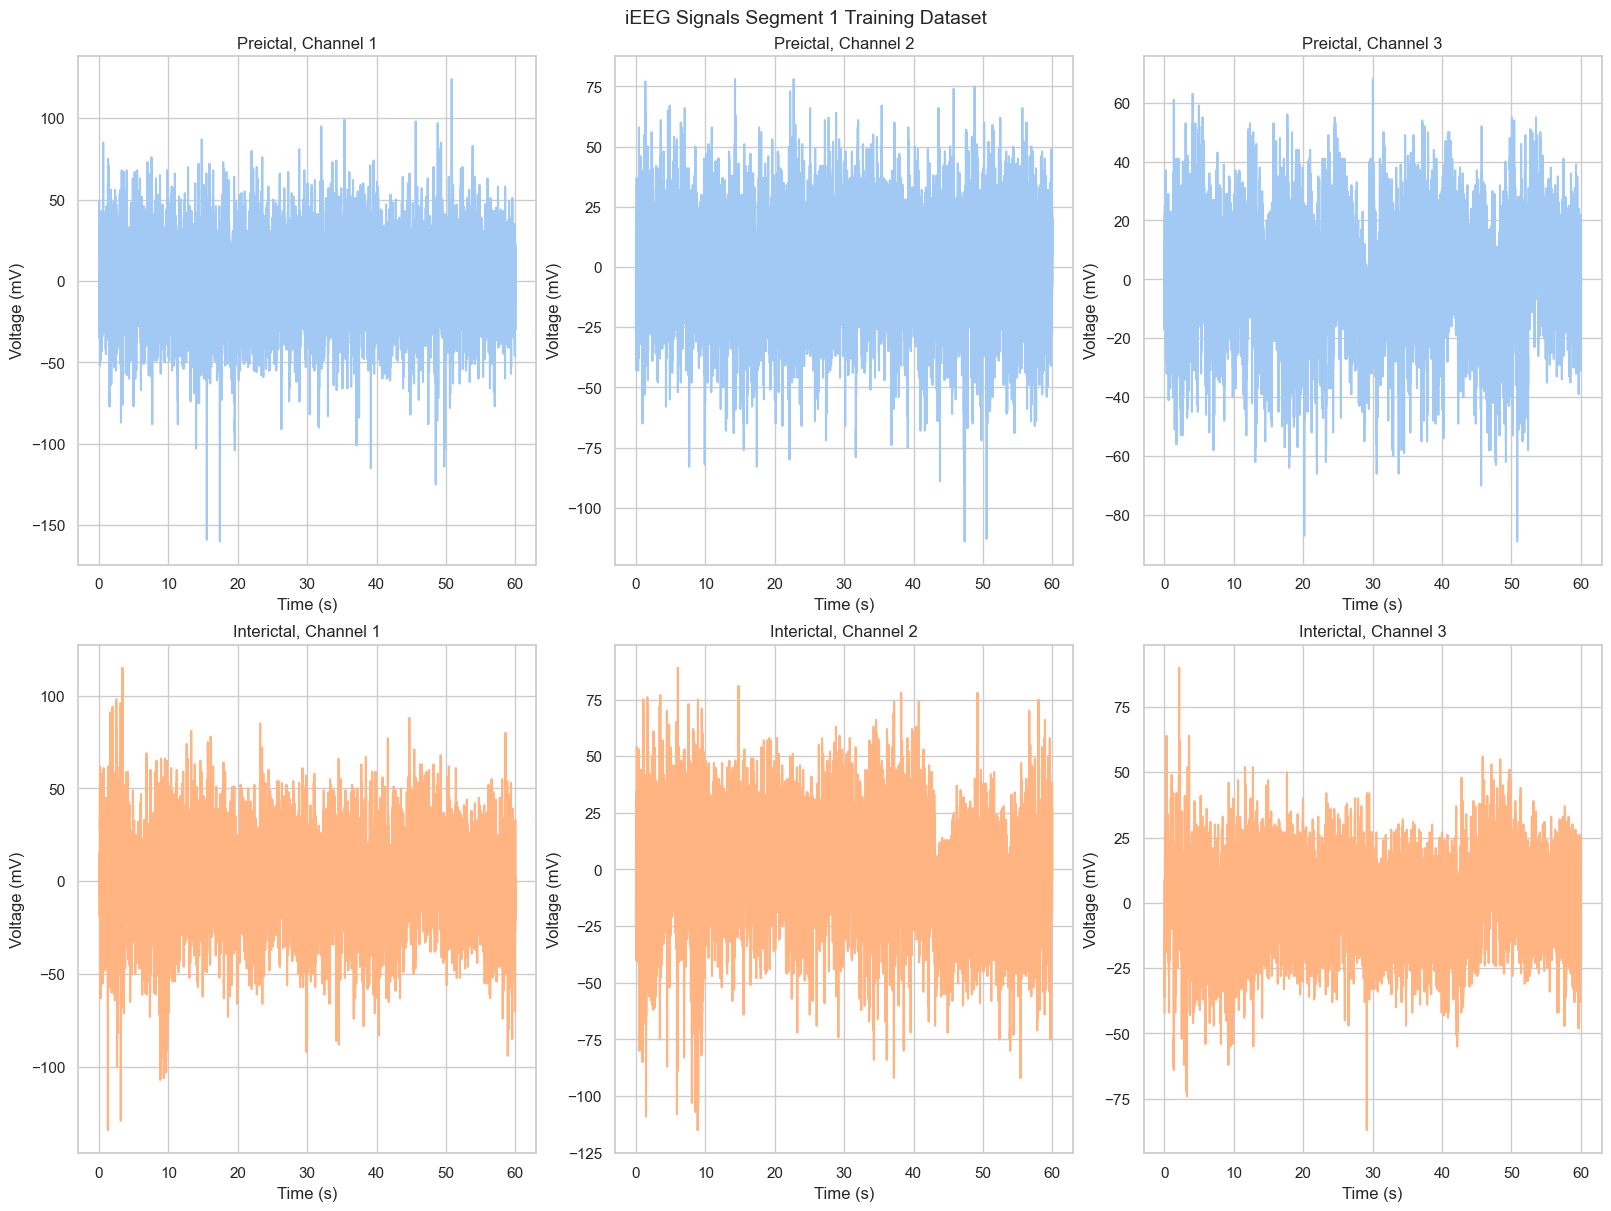

In [22]:
segment_to_plot = 1
channels_to_plot = [1, 2, 3]

sampling_freq = preictal_training[segment_to_plot - 1]["sampling_frequency"]

time_window = 60
samples_window = round(sampling_freq * time_window)

time = range(samples_window) / sampling_freq

fig, axes = plt.subplots(2, len(channels_to_plot), figsize=(16, 12), constrained_layout=True)

for idx, channel in enumerate(channels_to_plot):
    preictal_training_seg_example = preictal_training[segment_to_plot - 1]["eeg_data"][channel - 1, 0:samples_window]
    interictal_training_seg_example = interictal_training[segment_to_plot - 1]["eeg_data"][channel - 1, 0:samples_window]

    sns.lineplot(x=time, y=preictal_training_seg_example, ax=axes[0][idx], color=preictal_color)
    sns.lineplot(x=time, y=interictal_training_seg_example, ax=axes[1][idx], color=interictal_color)
    
    axes[0][idx].set_title(f"Preictal, Channel {channel}")
    axes[1][idx].set_title(f"Interictal, Channel {channel}")

    axes[0][idx].set_ylabel("Voltage (mV)")
    axes[1][idx].set_ylabel("Voltage (mV)")

    axes[0][idx].set_xlabel("Time (s)")
    axes[1][idx].set_xlabel("Time (s)")

fig.suptitle(f"iEEG Signals Segment {segment_to_plot} Training Dataset", fontsize=14)


### Descriptive Statistics in Time Domain

In this section, basic time domain statistics (mean, std, max, min) are calculated over 30s-long preictal and interictal iEEG slices. The slices are taken from a subset the training set.

In [23]:
sample_segments_idx = range(0, 24)
slice_time_duration = 30

sample_preictal_segments = [preictal_training[segment_idx]["eeg_data"] for segment_idx in sample_segments_idx]
sample_interictal_segments =  [interictal_training[segment_idx]["eeg_data"] for segment_idx in sample_segments_idx]

fs = preictal_training[0]["sampling_frequency"]

# All 30s-long slices are stored in the following lists
all_preictal_slices = []
all_interictal_slices = []

for eeg_segment in sample_preictal_segments:
    all_preictal_slices = all_preictal_slices + eeg_slices(eeg_segment, fs, slice_time_duration)
    
for eeg_segment in sample_interictal_segments:
    all_interictal_slices = all_interictal_slices + eeg_slices(eeg_segment, fs, slice_time_duration)

In [24]:
print("Number of preictal 30s slices: ", len(all_preictal_slices))
print("Number of interictal 30s slices: ", len(all_interictal_slices))

Number of preictal 30s slices:  480
Number of interictal 30s slices:  480


In [25]:
# The basic time domain statistics are calculated for every 30s-long slices and stored in lists
 
max_voltage_per_channel_preictal = [np.max(segment, axis=1) for segment in all_preictal_slices]
min_voltage_per_channel_preictal = [np.min(segment, axis=1) for segment in all_preictal_slices]
mean_voltage_per_channel_preictal = [np.mean(segment, axis=1) for segment in all_preictal_slices]
std_voltage_per_channel_preictal = [np.std(segment, axis=1) for segment in all_preictal_slices]

max_voltage_per_channel_interictal = [np.max(segment, axis=1) for segment in all_interictal_slices]
min_voltage_per_channel_interictal = [np.min(segment, axis=1) for segment in all_interictal_slices]
mean_voltage_per_channel_interictal = [np.mean(segment, axis=1) for segment in all_interictal_slices]
std_voltage_per_channel_interictal = [np.std(segment, axis=1) for segment in all_interictal_slices]

In [26]:
# Transform the previous lists in pandas dataframes to make analysis easier
# The columns are the channels and the rows are the slices of data

num_channels = len(max_voltage_per_channel_preictal[0])

# Preictal
max_preictal_df = pd.DataFrame(max_voltage_per_channel_preictal,
             columns=[f" Max Ch{x + 1}" for x in range(num_channels)])

min_preictal_df = pd.DataFrame(min_voltage_per_channel_preictal,
             columns=[f" Min Ch{x + 1}" for x in range(num_channels)])

mean_preictal_df = pd.DataFrame(mean_voltage_per_channel_preictal,
             columns=[f" Mean Ch{x + 1}" for x in range(num_channels)])

std_preictal_df = pd.DataFrame(std_voltage_per_channel_preictal,
             columns=[f"Std Ch{x + 1}" for x in range(num_channels)])

# Interictal
max_interictal_df = pd.DataFrame(max_voltage_per_channel_interictal,
             columns=[f" Max Ch{x + 1}" for x in range(num_channels)])

min_interictal_df = pd.DataFrame(min_voltage_per_channel_interictal,
             columns=[f" Min Ch{x + 1}" for x in range(num_channels)])

mean_interictal_df = pd.DataFrame(mean_voltage_per_channel_interictal,
             columns=[f" Mean Ch{x + 1}" for x in range(num_channels)])

std_interictal_df = pd.DataFrame(std_voltage_per_channel_interictal,
             columns=[f"Std Ch{x + 1}" for x in range(num_channels)])

print("shape of mean_preictal_df: ", mean_preictal_df.shape)
print("shape of std_preictal_df: ", std_preictal_df.shape)

shape of mean_preictal_df:  (480, 16)
shape of std_preictal_df:  (480, 16)


In [27]:
# Std comparison
avg_std_preictal_s = std_preictal_df.mean()
avg_std_interictal_s = std_interictal_df.mean()
std_comparison_df = pd.DataFrame({
    "Preictal": avg_std_preictal_s,
    "Interictal": avg_std_interictal_s
})

# Mean comparison
avg_mean_preictal_s = mean_preictal_df.mean()
avg_mean_interictal_s = mean_interictal_df.mean()
mean_comparison_df = pd.DataFrame({
    "Preictal": avg_mean_preictal_s,
    "Interictal": avg_mean_interictal_s
})

# Max comparison
avg_max_preictal_s = max_preictal_df.mean()
avg_max_interictal_s = max_interictal_df.mean()
max_comparison_df = pd.DataFrame({
    "Preictal": avg_max_preictal_s,
    "Interictal": avg_max_interictal_s
})

# Min comparison
avg_min_preictal_s = min_preictal_df.mean()
avg_min_interictal_s = min_interictal_df.mean()
min_comparison_df = pd.DataFrame({
    "Preictal": avg_min_preictal_s,
    "Interictal": avg_min_interictal_s
})

# Convert DataFrames to HTML and display side by side
html_content = f"""
<div style="display: flex; gap: 50px;">
    <div>{max_comparison_df.to_html()}</div>
    <div>{min_comparison_df.to_html()}</div>
    <div>{mean_comparison_df.to_html()}</div>
    <div>{std_comparison_df.to_html()}</div>
</div>
"""

display(HTML(html_content))

### ANOVA Hypothesis Test for the Standard Deviation

In [28]:
# Changing the name of the columns so that the dataframes can be combined and melted
std_preictal_df.columns = list(range(1, num_channels + 1))
std_interictal_df.columns = list(range(1, num_channels + 1))

# Adding the labels
std_preictal_df["Label"] = "Preictal"
std_interictal_df["Label"] = "Interictal"

# Combining both dataframes
all_std_combined_df = pd.concat([std_preictal_df, std_interictal_df])


In [29]:
# Melt the dataframe to reshape it for the ANOVA Test and plotting
melted_std_df = all_std_combined_df.melt(id_vars=['Label'], var_name='Channel', value_name='STD')
melted_std_df["Channel"] = melted_std_df["Channel"].astype(int)  # Ensuring channel is treated as numerical
melted_std_df

Label  Channel        STD
0        Preictal        1  24.759282
1        Preictal        1  24.417649
2        Preictal        1  23.045752
3        Preictal        1  23.041705
4        Preictal        1  24.311538
...           ...      ...        ...
15355  Interictal       16  27.891174
15356  Interictal       16  28.518724
15357  Interictal       16  28.424381
15358  Interictal       16  28.105147
15359  Interictal       16  28.942590

[15360 rows x 3 columns]

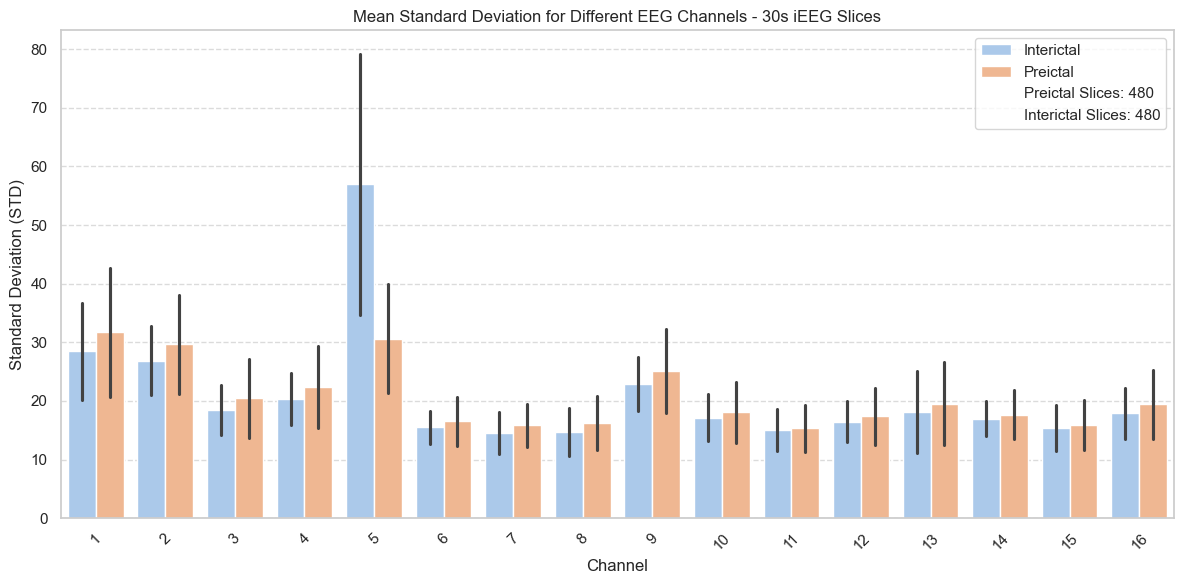

In [30]:
# Plot the barplot with seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x='Channel', y='STD', data=melted_std_df, hue='Label', errorbar="sd", palette="pastel", hue_order=["Interictal", "Preictal"])

# Customize the plot
plt.xlabel("Channel")
plt.ylabel("Standard Deviation (STD)")
plt.title("Mean Standard Deviation for Different EEG Channels - 30s iEEG Slices")
plt.xticks(rotation=45)

# Customize the legend labels
handles, labels = plt.gca().get_legend_handles_labels()
handles.append(plt.Line2D([0], [0], color='none', label=f"Preictal Slices: {len(std_preictal_df)}"))
handles.append(plt.Line2D([0], [0], color='none', label=f"Interictal Slices: {len(std_interictal_df)}"))

# Add updated legend
plt.legend(handles=handles, loc='upper right')

plt.tight_layout()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

#### Goal

The goal of this two-way ANOVA test is to determine whether the **standard deviation (STD)** of EEG signals varies significantly across different **EEG channels** and between two classes of EEG data (**interictal** and **preictal**).

- By examining whether the STD differs across EEG channels, we aim to identify whether specific channels contribute more strongly to the variance in signal characteristics.  
- If the STD varies significantly between interictal and preictal states, this would suggest that these features may serve as effective discriminators for classification tasks.  
- We also investigate whether the relationship between EEG channel and STD depends on the EEG class, which could indicate interaction effects useful for understanding EEG signal dynamics.



#### Null Hypotheses (H₀)

1. **Main Effect of EEG Class**:  
   H₀₁: The mean STD does not vary between interictal and preictal EEG classes.  
   (i.e., there is no significant difference in STD between the two classes.)  

2. **Main Effect of EEG Channels**:  
   H₀₂: The mean STD does not vary across EEG channels.  
   (i.e., there is no significant difference in STD between the channels.)  

3. **Interaction Effect**:  
   H₀₃: There is no interaction effect between EEG channel and class on STD.  
   (i.e., the relationship between STD and EEG channel does not depend on the EEG class.)  


#### Conditions for Rejection

- For any hypothesis, the null hypothesis is rejected if the **p-value** from the ANOVA test is **less than the significance level (α)**, typically set at 0.05.  
  - If **p-value < 0.05**, reject H₀ (significant effect exists).  
  - If **p-value ≥ 0.05**, fail to reject H₀ (no significant effect).  




In [31]:
# Perform two-way ANOVA
model = ols("STD ~ C(Label) + C(Channel) + C(Label):C(Channel)", data=melted_std_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)  # Type 2 ANOVA table

# Display ANOVA results
print("ANOVA Results by Channel:")
anova_table

# Observation: if the test is performed only for 400 slices of preictal and interictal each, then the first H0 fails to be rejected

ANOVA Results by Channel:


sum_sq       df            F    PR(>F)
C(Label)                241.002209      1.0     5.159093  0.023139
C(Channel)           835618.583901     15.0  1192.529615  0.000000
C(Label):C(Channel)  176785.895607     15.0   252.295030  0.000000
Residual             716033.183684  15328.0          NaN       NaN

#### **Conclusion**

1.The STD differs significantly between interictal and preictal states, suggesting that STD alone could be a discriminator for these two states. However, the p-value is not as low as for the other null hypothesis. 

2.The STD varies significantly across channels, indicating that certain EEG channels exhibit stronger signal variability than others, which could be leveraged for feature selection. The p-value is very low, which indicates that the evidence towards the variation across channels is very strong. 

3.The relationship between channel-specific STD and EEG class is significant, suggesting that the effect of EEG channel on STD depends on whether the data is interictal or preictal. This indicates that certain channels may show distinct variability patterns between the two states. The p-value is very low, which indicates that the evidence towards the variation between labels within a channel is very strong. 

### Correlation between Channels

In [32]:
idx_seg_to_analyse_corr = 1

preictal_training_seg = preictal_training[idx_seg_to_analyse_corr - 1]["eeg_data"]
preictal_training_seg_df = pd.DataFrame(preictal_training_seg.T)
preictal_channel_corr = preictal_training_seg_df.corr()

interictal_training_seg = interictal_training[idx_seg_to_analyse_corr - 1]["eeg_data"]
interictal_training_seg_df = pd.DataFrame(interictal_training_seg.T)
interictal_channel_corr = interictal_training_seg_df.corr()


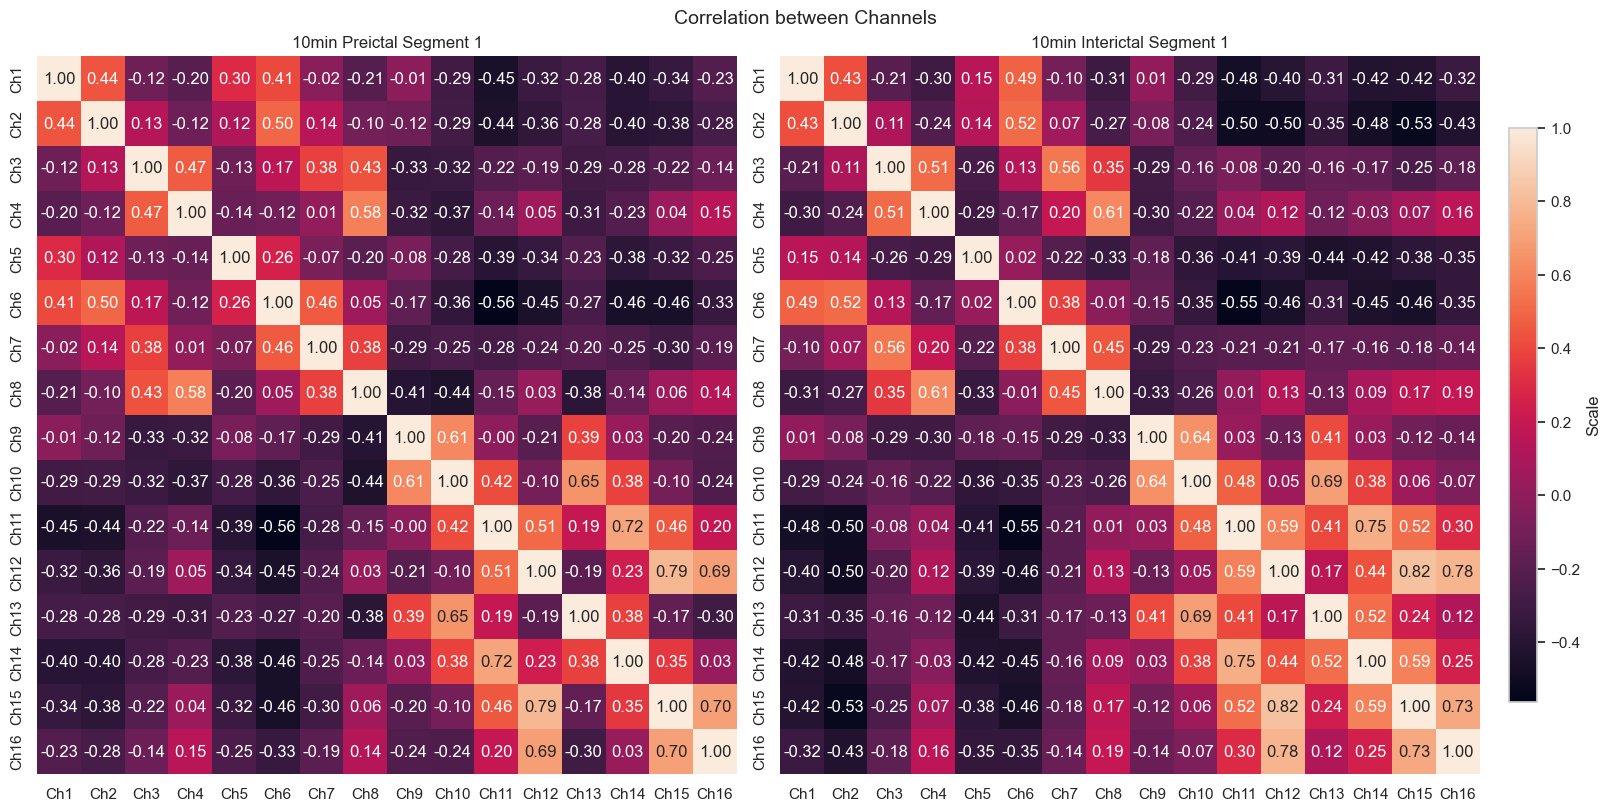

In [33]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8), constrained_layout=True)

fig.suptitle(f"Correlation between Channels", fontsize=14)

num_channels = len(preictal_channel_corr.columns)
channel_names = [f"Ch{idx + 1}" for idx in range(num_channels)]

# Find the min and max values across both datasets
vmin = min(preictal_channel_corr.values.min(), interictal_channel_corr.values.min())
vmax = max(preictal_channel_corr.values.max(), interictal_channel_corr.values.max())

sns.heatmap(preictal_channel_corr, ax=axes[0], vmin=vmin, vmax=vmax, cbar=False, annot=True, xticklabels=channel_names, yticklabels=channel_names, fmt=".2f")
sns.heatmap(interictal_channel_corr, ax=axes[1], vmin=vmin, vmax=vmax, annot=True, cbar=False, xticklabels=channel_names, yticklabels=channel_names, fmt=".2f")

# Add a single color bar to the side
cbar = fig.colorbar(axes[0].collections[0], ax=axes, orientation="vertical", shrink=0.8, pad=0.02)
cbar.set_label("Scale")

axes[0].set_title(f"10min Preictal Segment {idx_seg_to_analyse_corr}")
axes[1].set_title(f"10min Interictal Segment {idx_seg_to_analyse_corr}")

plt.show()

Observations:
- Nearby channels demonstrate a considerable correlation (elements close to the main diagonal)
- Channels further away from each other show lower covariance (elements further away from the main diagonal)

### Autocorrelation

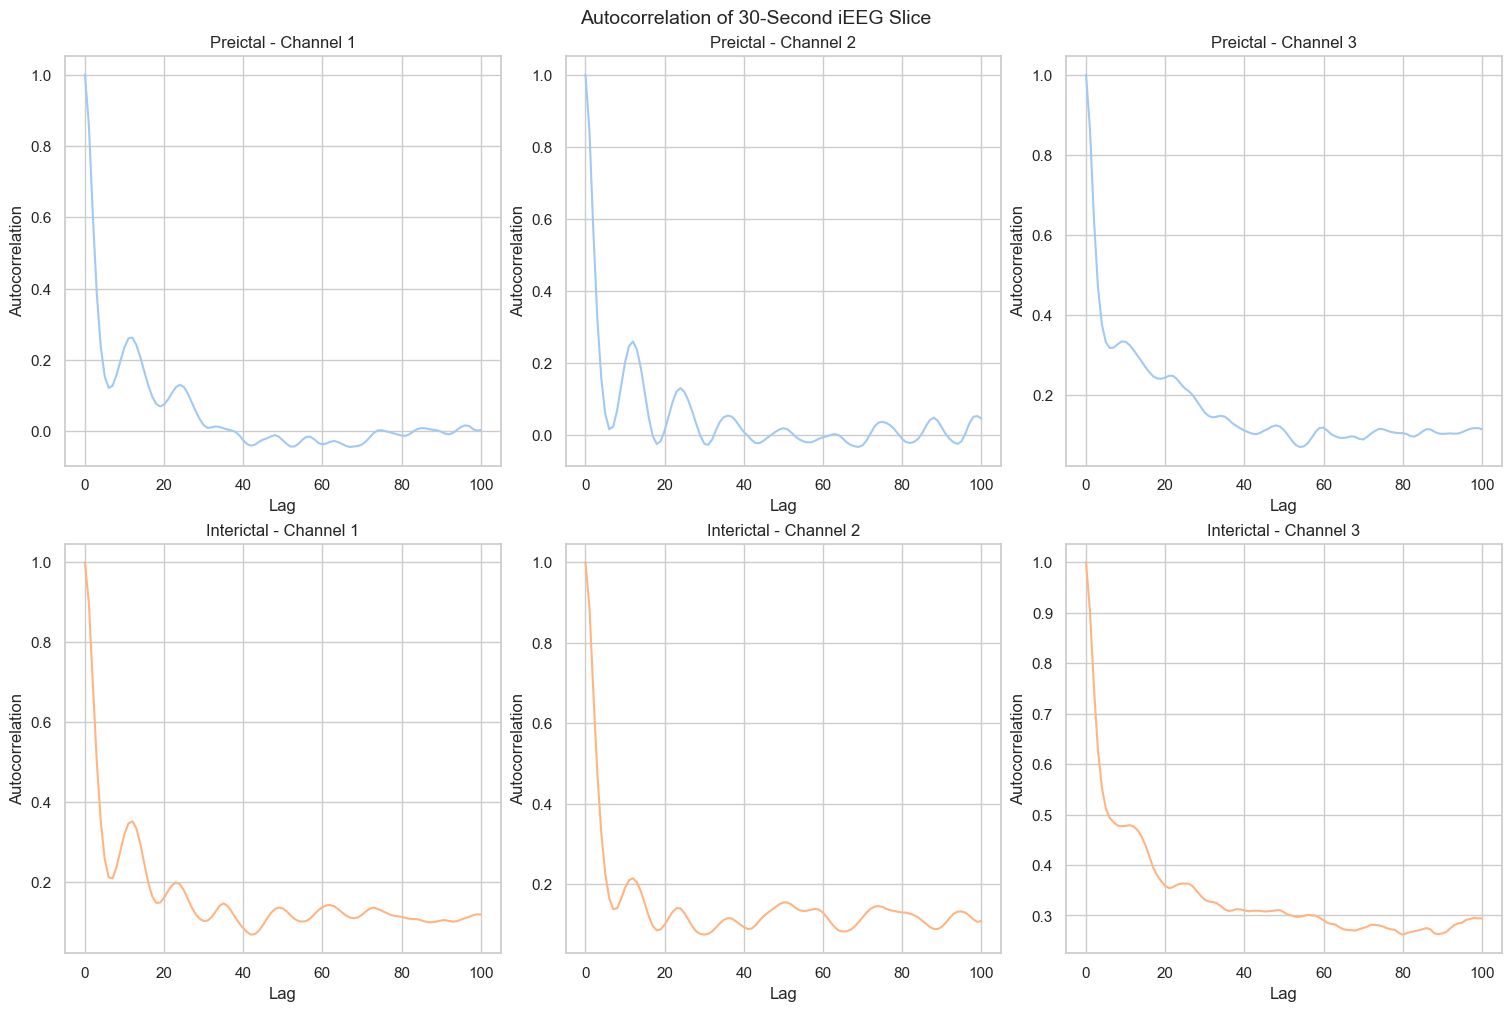

In [34]:
from statsmodels.tsa.stattools import acf

idx_eeg_slice_to_plot = 10
preictal_30s_slice = all_preictal_slices[idx_eeg_slice_to_plot]
interictal_30s_slice = all_interictal_slices[idx_eeg_slice_to_plot]

# Select 3 channels to compare (indices can be adjusted)
selected_channels = [0, 1, 2]
lags = 100  # Number of lags to display

# Prepare autocorrelations for both slices
autocorrs_preictal = {ch: acf(preictal_30s_slice[ch], nlags=lags) for ch in selected_channels}
autocorrs_interictal = {ch: acf(interictal_30s_slice[ch], nlags=lags) for ch in selected_channels}

# Plotting with seaborn: 2 rows, 3 columns (3 channels per row)
fig, axes = plt.subplots(2, 3, figsize=(15, 10), constrained_layout=True)
axes = axes.flatten()

# Plot preictal autocorrelations (first row)
for i, ch in enumerate(selected_channels):
    sns.lineplot(x=range(lags+1), y=autocorrs_preictal[ch], ax=axes[i], color=preictal_color)
    axes[i].set_title(f"Preictal - Channel {ch + 1}")
    axes[i].set_xlabel("Lag")
    axes[i].set_ylabel("Autocorrelation")

# Plot interictal autocorrelations (second row)
for i, ch in enumerate(selected_channels):
    sns.lineplot(x=range(lags+1), y=autocorrs_interictal[ch], ax=axes[i + 3], color=interictal_color)
    axes[i + 3].set_title(f"Interictal - Channel {ch + 1}")
    axes[i + 3].set_xlabel("Lag")
    axes[i + 3].set_ylabel("Autocorrelation")

fig.suptitle(f"Autocorrelation of 30-Second iEEG Slice", fontsize=14)
plt.show()


Observations:
 - The time domain features of the signal within a single channel are correlated. A PCA could then be used two reduce such "redundancy" of information in the time domain, reducing the number of time domain features for each channel

## Analysis of iEEG Signals in Frequency Domain

### Short Time Fourier Transform (STFT) plots for single channel

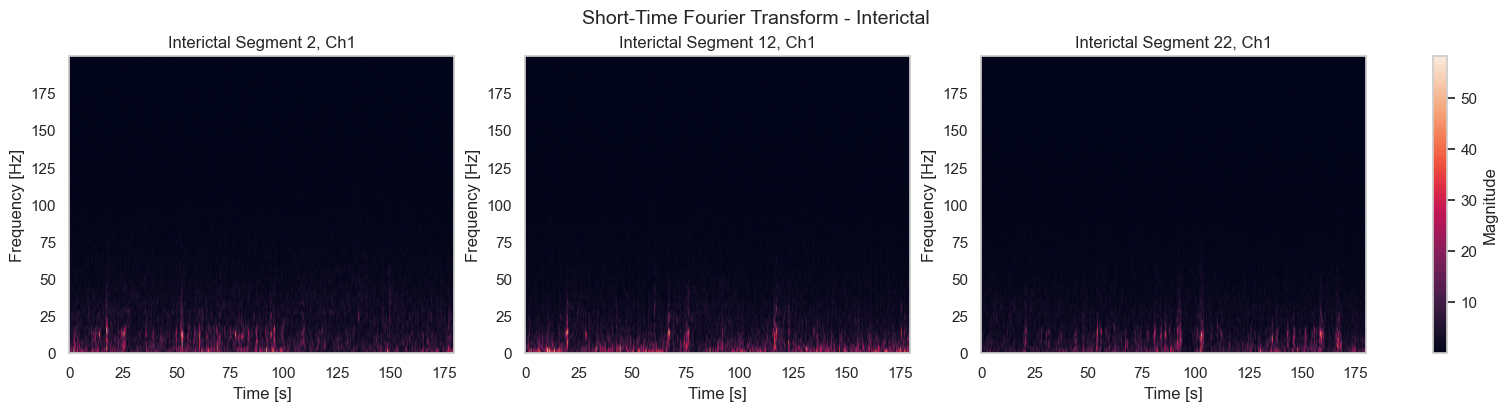

In [35]:
# Set the range of segments to plot
segments_to_plot = [2, 12, 22]  # Change this list to any segment numbers you want to plot
ch_to_plot = 1

# Create a figure with a single row and columns equal to the number of segments
num_segments = len(segments_to_plot)

# Create the subplot layout (1 row, num_segments columns)
fig, axes = plt.subplots(1, num_segments, figsize=(5 * num_segments, 4), constrained_layout=True)

# Loop through each segment and plot its STFT
for idx, segment_to_plot in enumerate(segments_to_plot):
    # Get the specific segment data
    interictal_segment_to_plot = interictal_training[segment_to_plot-1]

    fs = interictal_segment_to_plot["sampling_frequency"]
    time_window = 180
    samples_window = round(fs * time_window)

    signal = interictal_segment_to_plot["eeg_data"][ch_to_plot-1, 0:samples_window-1]

    # Compute the Short-Time Fourier Transform (STFT)
    f, t_stft, Zxx = stft(signal, fs, nperseg=256)

    # Plot the STFT for this segment
    ax = axes[idx]  # Access the appropriate subplot
    c = ax.pcolormesh(t_stft, f, np.abs(Zxx), shading='gouraud')
    ax.set_title(f'Interictal Segment {segment_to_plot}, Ch{ch_to_plot}')
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Frequency [Hz]')
    
fig.colorbar(c, ax=axes, orientation='vertical', label='Magnitude')
fig.suptitle(f"Short-Time Fourier Transform - Interictal", fontsize=14)
plt.show()


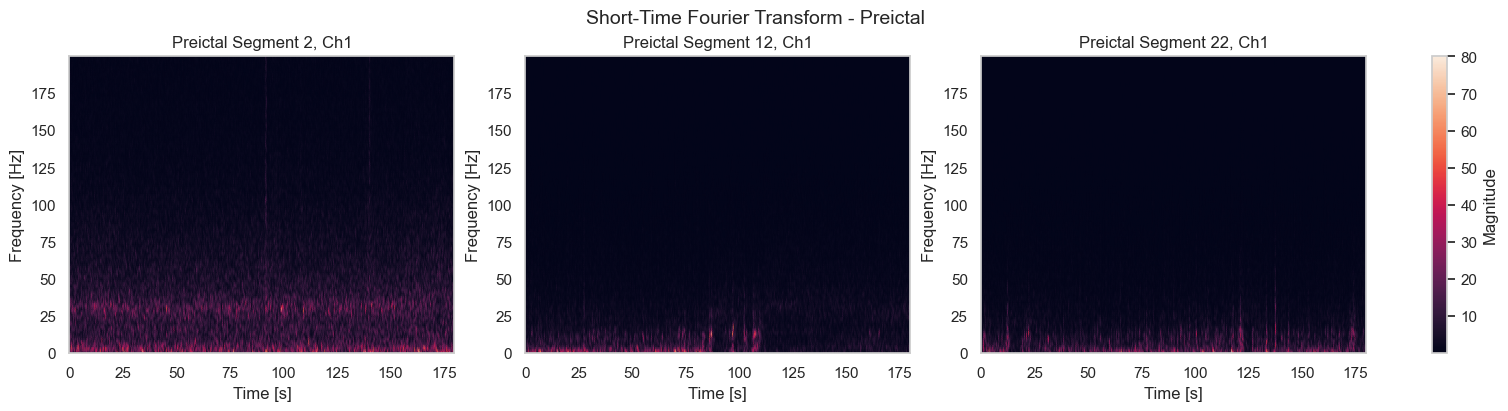

In [36]:
import matplotlib.pyplot as plt
from scipy.signal import stft

# Set the range of segments to plot
segments_to_plot = [2, 12, 22]  # Change this list to any segment numbers you want to plot
ch_to_plot = 1

# Create a figure with a single row and columns equal to the number of segments
num_segments = len(segments_to_plot)

# Create the subplot layout (1 row, num_segments columns)
fig, axes = plt.subplots(1, num_segments, figsize=(5 * num_segments, 4), constrained_layout=True)

# Loop through each segment and plot its STFT
for idx, segment_to_plot in enumerate(segments_to_plot):
    # Get the specific segment data
    preictal_segment_to_plot = preictal_training[segment_to_plot-1]

    fs = preictal_segment_to_plot["sampling_frequency"]
    time_window = 180
    samples_window = round(fs * time_window)

    signal = preictal_segment_to_plot["eeg_data"][ch_to_plot-1, 0:samples_window-1]

    # Compute the Short-Time Fourier Transform (STFT)
    f, t_stft, Zxx = stft(signal, fs, nperseg=256)

    # Plot the STFT for this segment
    ax = axes[idx]  # Access the appropriate subplot
    c = ax.pcolormesh(t_stft, f, np.abs(Zxx), shading='gouraud')
    ax.set_title(f'Preictal Segment {segment_to_plot}, Ch{ch_to_plot}')
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Frequency [Hz]')

fig.colorbar(c, ax=axes, orientation='vertical', label='Magnitude')
fig.suptitle(f"Short-Time Fourier Transform - Preictal", fontsize=14)
plt.show()


Observations:
- In both cases, the energy is more concentrated across lower frequencies, particularly concentrated around the 0-50 Hz range, which is typical for EEG signals.
- Both preictal and interictal data doesn't seem to contain a lot of noise. There are just a few abrupt changes in the power of frequency bands.
    - One example of this abrupt change can be seen around 100s in the preictal segments 2 and 12. Probably, this was caused by an artifact or noise (muscle movements, electrode shifts, or electrical interference)

### Comparison STFT plots across classes and channels

#### Segment 2 Example

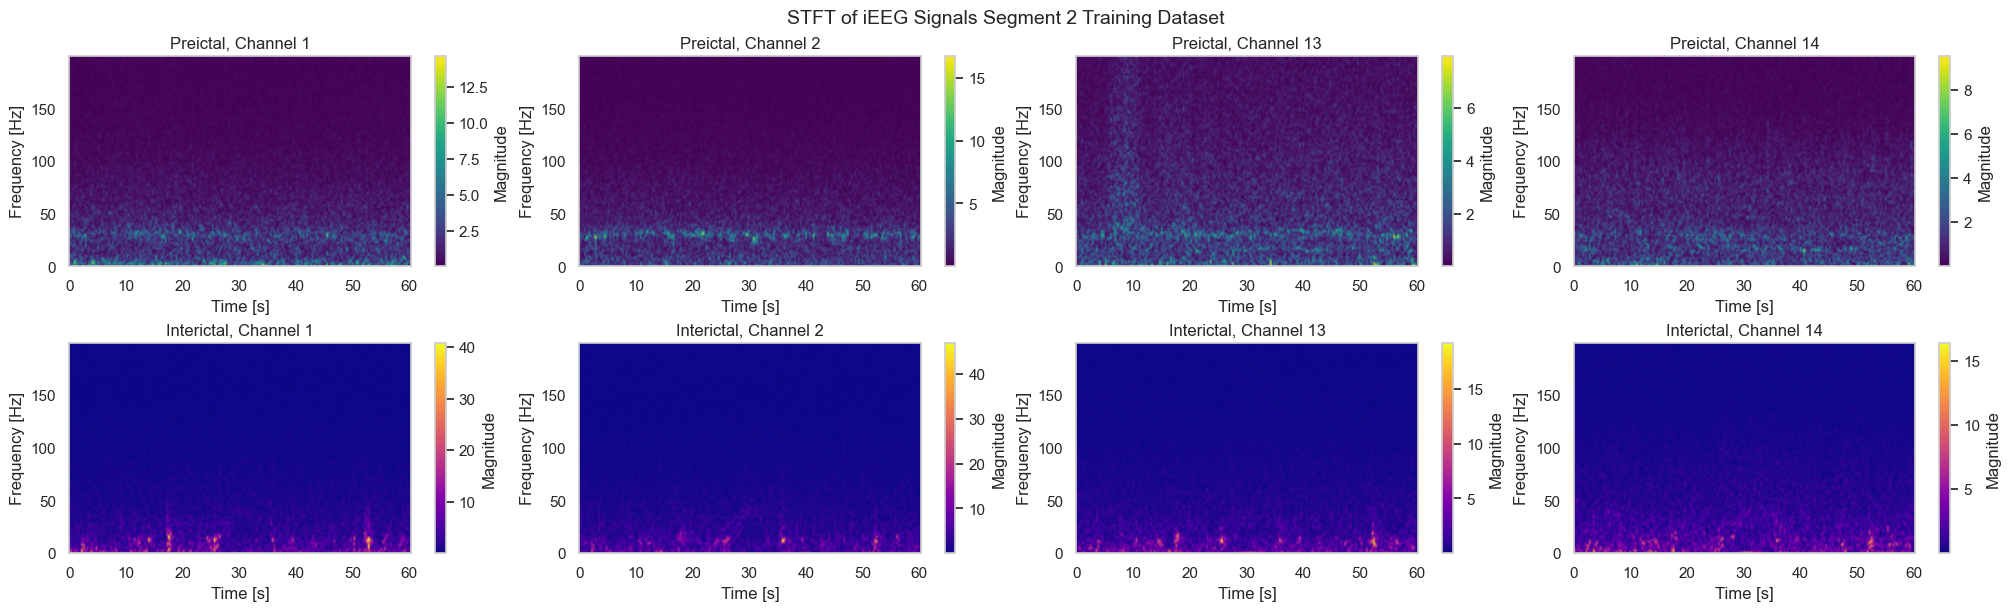

In [37]:
# Parameters
segment_to_plot = 2
channels_to_plot = [1, 2, 13, 14]
time_window = 60

# Extract sampling frequency
sampling_freq = preictal_training[segment_to_plot - 1]["sampling_frequency"]

# Compute the number of samples in the desired time window
samples_window = round(sampling_freq * time_window)

# Initialize time vector for plotting
time = np.arange(samples_window) / sampling_freq

# Create subplots
fig, axes = plt.subplots(2, len(channels_to_plot), figsize=(20, 6), constrained_layout=True)

for idx, channel in enumerate(channels_to_plot):
    # Extract EEG data for the current channel and segment
    preictal_data = preictal_training[segment_to_plot - 1]["eeg_data"][channel - 1, 0:samples_window]
    interictal_data = interictal_training[segment_to_plot - 1]["eeg_data"][channel - 1, 0:samples_window]

    # Compute STFT for preictal data
    f_pre, t_pre, Zxx_pre = stft(preictal_data, fs=sampling_freq, nperseg=256)
    f_inter, t_inter, Zxx_inter = stft(interictal_data, fs=sampling_freq, nperseg=256)

    # Plot STFT for preictal data
    pcm1 = axes[0][idx].pcolormesh(t_pre, f_pre, np.abs(Zxx_pre), shading='gouraud', cmap='viridis')
    fig.colorbar(pcm1, ax=axes[0][idx], label='Magnitude')
    axes[0][idx].set_title(f"Preictal, Channel {channel}")
    axes[0][idx].set_ylabel("Frequency [Hz]")
    axes[0][idx].set_xlabel("Time [s]")

    # Plot STFT for interictal data
    pcm2 = axes[1][idx].pcolormesh(t_inter, f_inter, np.abs(Zxx_inter), shading='gouraud', cmap='plasma')
    fig.colorbar(pcm2, ax=axes[1][idx], label='Magnitude')
    axes[1][idx].set_title(f"Interictal, Channel {channel}")
    axes[1][idx].set_ylabel("Frequency [Hz]")
    axes[1][idx].set_xlabel("Time [s]")

fig.suptitle(f"STFT of iEEG Signals Segment {segment_to_plot} Training Dataset", fontsize=14)
plt.show()


#### Segment 12 Example

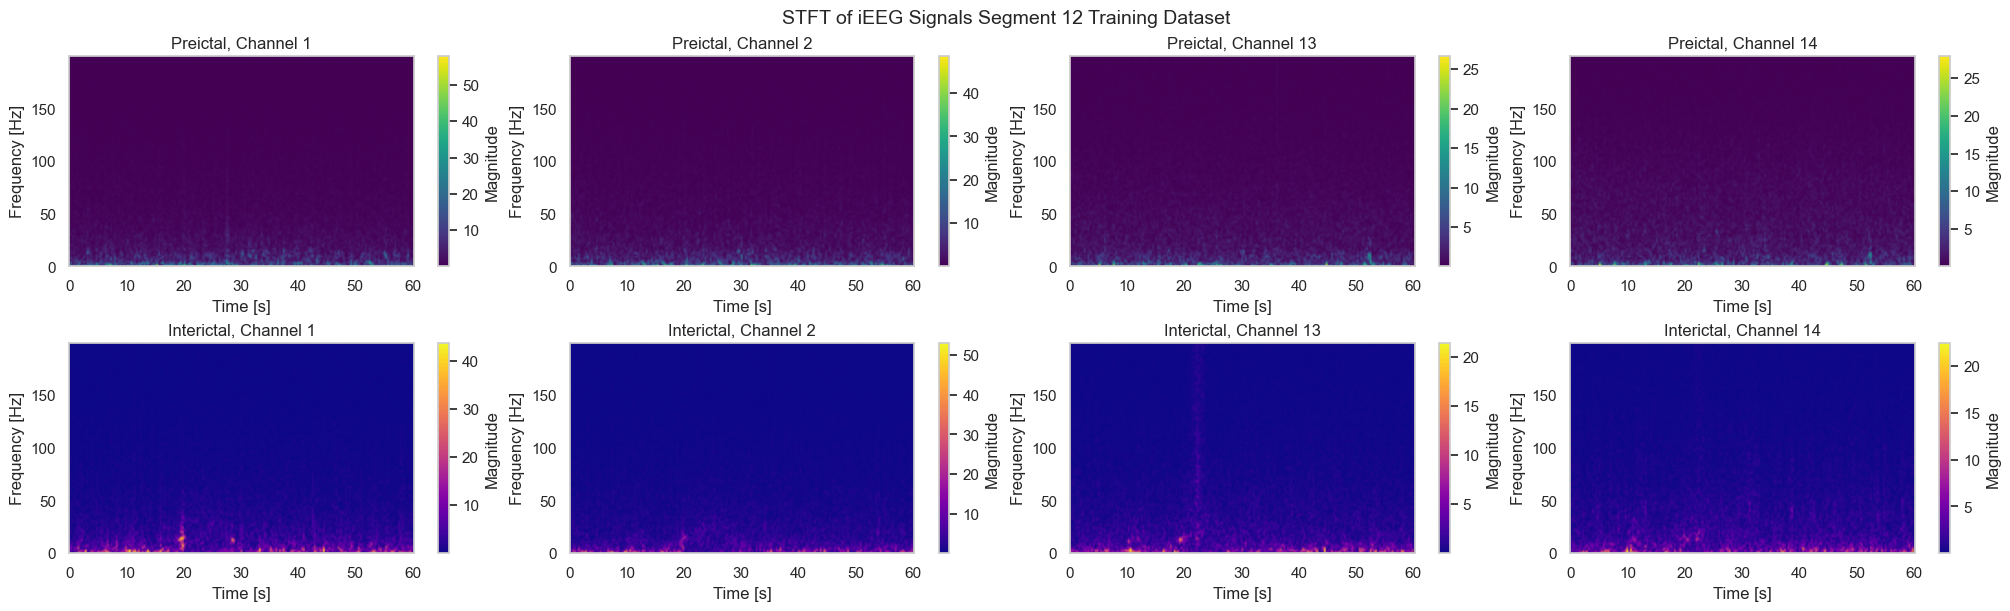

In [38]:
# Parameters
segment_to_plot = 12
channels_to_plot = [1, 2, 13, 14]
time_window = 60

# Extract sampling frequency
sampling_freq = preictal_training[segment_to_plot - 1]["sampling_frequency"]

# Compute the number of samples in the desired time window
samples_window = round(sampling_freq * time_window)

# Initialize time vector for plotting
time = np.arange(samples_window) / sampling_freq

# Create subplots
fig, axes = plt.subplots(2, len(channels_to_plot), figsize=(20, 6), constrained_layout=True)

for idx, channel in enumerate(channels_to_plot):
    # Extract EEG data for the current channel and segment
    preictal_data = preictal_training[segment_to_plot - 1]["eeg_data"][channel - 1, 0:samples_window]
    interictal_data = interictal_training[segment_to_plot - 1]["eeg_data"][channel - 1, 0:samples_window]

    # Compute STFT for preictal data
    f_pre, t_pre, Zxx_pre = stft(preictal_data, fs=sampling_freq, nperseg=256)
    f_inter, t_inter, Zxx_inter = stft(interictal_data, fs=sampling_freq, nperseg=256)

    # Plot STFT for preictal data
    pcm1 = axes[0][idx].pcolormesh(t_pre, f_pre, np.abs(Zxx_pre), shading='gouraud', cmap='viridis')
    fig.colorbar(pcm1, ax=axes[0][idx], label='Magnitude')
    axes[0][idx].set_title(f"Preictal, Channel {channel}")
    axes[0][idx].set_ylabel("Frequency [Hz]")
    axes[0][idx].set_xlabel("Time [s]")

    # Plot STFT for interictal data
    pcm2 = axes[1][idx].pcolormesh(t_inter, f_inter, np.abs(Zxx_inter), shading='gouraud', cmap='plasma')
    fig.colorbar(pcm2, ax=axes[1][idx], label='Magnitude')
    axes[1][idx].set_title(f"Interictal, Channel {channel}")
    axes[1][idx].set_ylabel("Frequency [Hz]")
    axes[1][idx].set_xlabel("Time [s]")

fig.suptitle(f"STFT of iEEG Signals Segment {segment_to_plot} Training Dataset", fontsize=14)
plt.show()

### Spectral Energy Analysis per Frequency Band

In [84]:
from pathlib import Path

# Add the root directory of the project to the Python path of the notebook's session
project_root = Path.cwd().parent  # Assuming the notebook is in the "notebooks" folder
sys.path.append(str(project_root))

# Import function for loading preprocessed data
from src.Preprocessing.utils import load_preprocessed_data

In [85]:
data_directory = project_root / "data" / "preprocessed" / "Dog_1_2_5s_slices"
print("Directory of the data: ")
print(data_directory)

file_name = "freq_domain_train.npz"

freq_domain_preprocessed = load_preprocessed_data(data_directory, file_name)

X_train_freq = freq_domain_preprocessed["X"]
y_train_freq = freq_domain_preprocessed["y"]

X_freq_preictal = X_train_freq[y_train_freq == 1]
X_freq_interictal = X_train_freq[y_train_freq == 0]

Directory of the data: 
c:\Users\User\Documents\Python Projects\SeizureSen\data\preprocessed\Dog_1_2_5s_slices
Data loaded from c:\Users\User\Documents\Python Projects\SeizureSen\data\preprocessed\Dog_1_2_5s_slices\freq_domain_train.npz


In [86]:
print("Number of preictal 5s slices: ", len(X_freq_preictal))
print("Number of interictal 5s slices: ", len(X_freq_interictal))

Number of preictal 5s slices:  7920
Number of interictal 5s slices:  117600


In [87]:
ch = 0 # Channel to analyze

n_samples_per_label = 1000

# Randomly select 1000 indices from the dataset
preictal_indices = np.random.choice(len(X_freq_preictal), n_samples_per_label, replace=False)
interictal_indices = np.random.choice(len(X_freq_interictal), n_samples_per_label, replace=False)

# Extract selected samples based on random indices
X_freq_subset_preictal_ch = [{feat: float(feat_value_ch[ch]) for feat, feat_value_ch in X_freq_preictal[i].items()} 
                             for i in preictal_indices]

X_freq_subset_interictal_ch = [{feat: float(feat_value_ch[ch]) for feat, feat_value_ch in X_freq_interictal[i].items()} 
                               for i in interictal_indices]

# Convert lists of dictionaries to DataFrames
freq_features_preictal_df = pd.concat([pd.DataFrame([slice_dict]) for slice_dict in X_freq_subset_preictal_ch], ignore_index=True)
freq_features_interictal_df = pd.concat([pd.DataFrame([slice_dict]) for slice_dict in X_freq_subset_interictal_ch], ignore_index=True)


In [89]:
freq_features_preictal_df["label"] = "Preictal"
freq_features_interictal_df["label"] = "Interictal"

# Combine both dataframes
freq_features_df = pd.concat([freq_features_preictal_df, freq_features_interictal_df], axis=0)

In [90]:
freq_features_mean_power_df = freq_features_df[[col_name for col_name in freq_features_df.columns if "mean" in col_name] + ["label"]]
freq_features_std_power_df = freq_features_df[[col_name for col_name in freq_features_df.columns if "std" in col_name] + ["label"]]

In [91]:
freq_features_mean_power_df

delta_mean  theta_mean  alpha_mean  beta_mean  low_gamma_mean  \
0      3.377147    3.266091    3.008391   2.912120        2.774165   
1      3.699260    3.606048    3.566484   3.332198        2.931325   
2      3.930374    3.592324    3.547147   3.117459        2.758784   
3      3.848696    3.620899    3.519734   3.078126        2.714111   
4      3.263225    3.177327    3.074825   2.922928        2.830548   
..          ...         ...         ...        ...             ...   
995    3.178487    3.127885    3.053855   3.222483        2.882258   
996    3.247821    3.242543    2.956080   3.095902        2.951688   
997    3.901010    3.823938    3.450440   3.300304        2.922549   
998    3.362802    3.278842    3.129716   2.974135        2.792141   
999    3.434903    3.334011    3.068711   2.978155        2.879672   

     mid_gamma_mean  high_gamma_1_mean  high_gamma_2_mean       label  
0          2.665063           2.474792           2.103844    Preictal  
1          2.684678           2.416227           1.987321    Preictal  
2          2.568028           2.346556           1.970330    Preictal  
3          2.537921           2.234947           1.910746    Preictal  
4          2.732234           2.489821           2.082347    Preictal  
..              ...                ...                ...         ...  
995        2.552089           2.301176           1.858149  Interictal  
996        2.729730           2.486504           2.001720  Interictal  
997        2.562893           2.303504           1.990351  Interictal  
998        2.534411           2.344508           1.923173  Interictal  
999        2.742285           2.513050           2.154328  Interictal  

[2000 rows x 9 columns]

In [92]:
freq_features_std_power_df

delta_std  theta_std  alpha_std  beta_std  low_gamma_std  mid_gamma_std  \
0     0.328804   0.233192   0.305860  0.315752       0.283668       0.280887   
1     0.225966   0.241174   0.309175  0.295268       0.254727       0.269297   
2     0.246659   0.267398   0.209886  0.380588       0.282240       0.245477   
3     0.380533   0.211454   0.186003  0.282693       0.329097       0.293954   
4     0.184075   0.182140   0.178704  0.301563       0.283016       0.277239   
..         ...        ...        ...       ...            ...            ...   
995   0.180174   0.213934   0.224478  0.289989       0.239231       0.272627   
996   0.282792   0.198996   0.243012  0.301214       0.316693       0.267585   
997   0.295844   0.283439   0.285536  0.350401       0.243265       0.305150   
998   0.453008   0.343075   0.357898  0.334588       0.256357       0.289914   
999   0.207277   0.202872   0.291080  0.307366       0.288090       0.237265   

     high_gamma_1_std  high_gamma_2_std       label  
0            0.293618          0.308286    Preictal  
1            0.308528          0.311340    Preictal  
2            0.305080          0.319557    Preictal  
3            0.289570          0.313700    Preictal  
4            0.300528          0.327095    Preictal  
..                ...               ...         ...  
995          0.277005          0.322879  Interictal  
996          0.265838          0.307775  Interictal  
997          0.293611          0.312253  Interictal  
998          0.285172          0.339419  Interictal  
999          0.273834          0.318504  Interictal  

[2000 rows x 9 columns]

In [93]:
bands_dict = {
    "delta": (0.1, 4),
    "theta": (4, 8),
    "alpha": (8, 12),
    "beta": (12, 30),
    "low_gamma": (30, 50),
    "mid_gamma": (50, 70),
    "high_gamma_1": (70, 100),
    "high_gamma_2": (100, 180),
}

def redefine_column_name(col_name, suffix="_mean"):
    band_name = col_name[:-len(suffix)]
    return f"{band_name} ({bands_dict[band_name][0]}-{bands_dict[band_name][1]} Hz)"

freq_features_mean_power_df.columns = [redefine_column_name(col) for col in freq_features_mean_power_df.columns if col != "label"] + ["label"]
freq_features_std_power_df.columns = [redefine_column_name(col, suffix="_std") for col in freq_features_std_power_df.columns if col != "label"] + ["label"]

print("New column names for mean power: ", freq_features_mean_power_df.columns)
print("New column names for std power: ", freq_features_std_power_df.columns)


New column names for mean power:  Index(['delta (0.1-4 Hz)', 'theta (4-8 Hz)', 'alpha (8-12 Hz)',
       'beta (12-30 Hz)', 'low_gamma (30-50 Hz)', 'mid_gamma (50-70 Hz)',
       'high_gamma_1 (70-100 Hz)', 'high_gamma_2 (100-180 Hz)', 'label'],
      dtype='object')
New column names for std power:  Index(['delta (0.1-4 Hz)', 'theta (4-8 Hz)', 'alpha (8-12 Hz)',
       'beta (12-30 Hz)', 'low_gamma (30-50 Hz)', 'mid_gamma (50-70 Hz)',
       'high_gamma_1 (70-100 Hz)', 'high_gamma_2 (100-180 Hz)', 'label'],
      dtype='object')


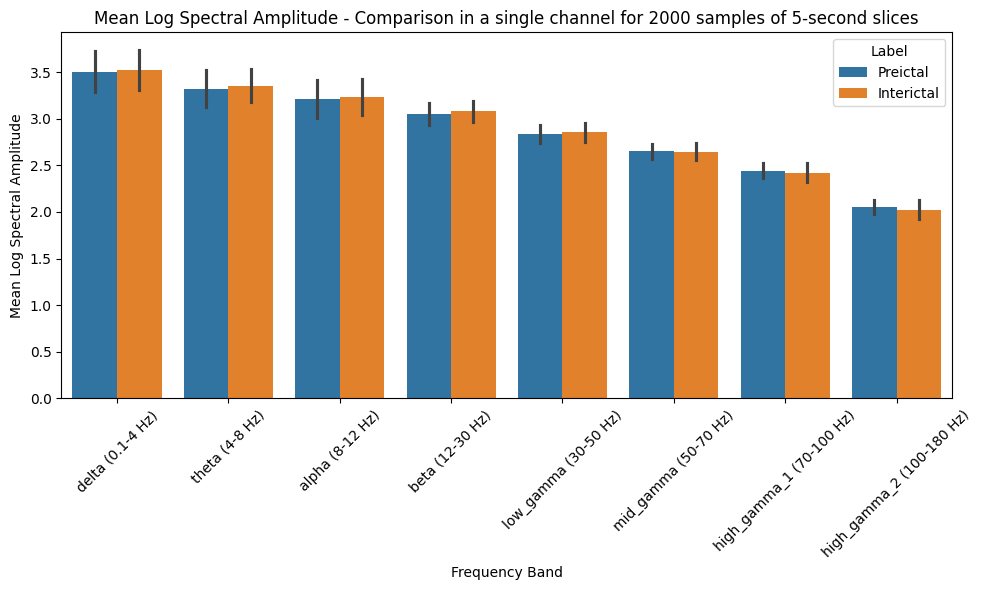

In [107]:
# Reshape to long format
melted_mean_df = freq_features_mean_power_df.melt(id_vars='label', var_name='features', value_name='value')

# Plot a grouped bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=melted_mean_df, x='features', y='value', hue='label', errorbar='sd')

# Customize plot
plt.xticks(rotation=45)
plt.title(f'Mean Log Spectral Amplitude - Comparison in a single channel for {2*n_samples_per_label} samples of 5-second slices')
plt.ylabel('Mean Log Spectral Amplitude')
plt.xlabel('Frequency Band')
plt.legend(title='Label')
plt.tight_layout()
plt.show()

In [95]:
melted_mean_df

label                   features     value
0        Preictal           delta (0.1-4 Hz)  3.377147
1        Preictal           delta (0.1-4 Hz)  3.699260
2        Preictal           delta (0.1-4 Hz)  3.930374
3        Preictal           delta (0.1-4 Hz)  3.848696
4        Preictal           delta (0.1-4 Hz)  3.263225
...           ...                        ...       ...
15995  Interictal  high_gamma_2 (100-180 Hz)  1.858149
15996  Interictal  high_gamma_2 (100-180 Hz)  2.001720
15997  Interictal  high_gamma_2 (100-180 Hz)  1.990351
15998  Interictal  high_gamma_2 (100-180 Hz)  1.923173
15999  Interictal  high_gamma_2 (100-180 Hz)  2.154328

[16000 rows x 3 columns]

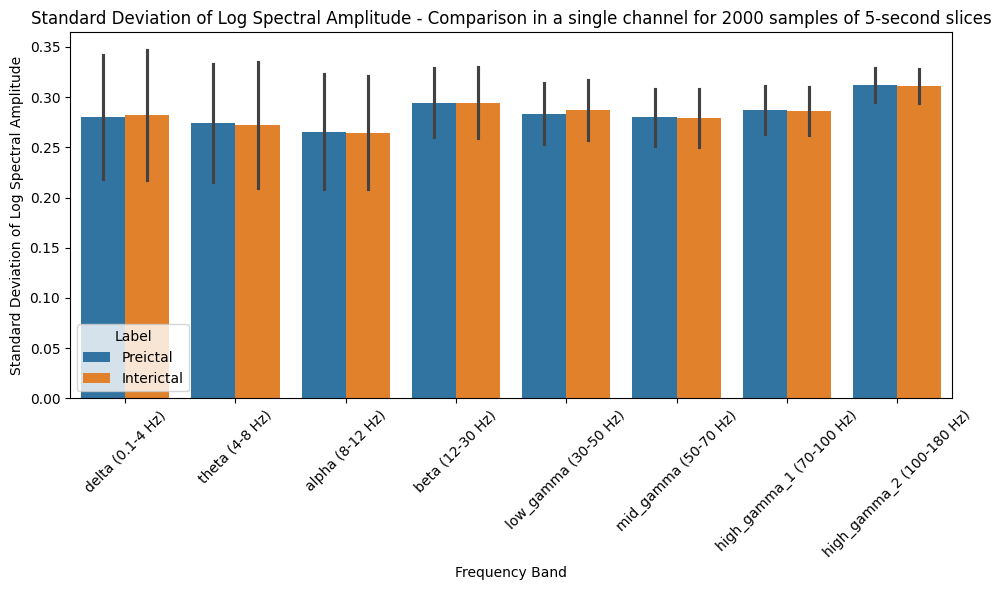

In [105]:
# Reshape to long format
melted_std_df = freq_features_std_power_df.melt(id_vars='label', var_name='features', value_name='value')

# Plot a grouped bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=melted_std_df, x='features', y='value', hue='label', errorbar='sd')

# Customize plot
plt.xticks(rotation=45)
plt.title(f'Standard Deviation of Log Spectral Amplitude - Comparison in a single channel for {2*n_samples_per_label} samples of 5-second slices')
plt.ylabel('Standard Deviation of Log Spectral Amplitude')
plt.xlabel('Frequency Band')
plt.legend(title='Label')
plt.tight_layout()
plt.show()


#### 2-way ANOVA Hypothesis Tests

##### Goal
The goal of this two-way ANOVA test is to investigate whether the spectral energy of EEG signals varies significantly across eight predefined frequency bands and between two classes of EEG data.
- By examining whether spectral energy differs across the eight frequency bands, we aim to identify frequency ranges that may hold distinctive information about the EEG data. Significant variation in energy across these bands would suggest that certain frequency ranges contribute more strongly to the signal's characteristics.
- If the spectral energy varies significantly between interictal and preictal states, this would indicate that these frequency-specific features could serve as effective discriminators for the classification task.

##### Null Hypotheses (H₀) for the Two-Way ANOVA
1. **Main Effect of Frequency Bands**:  
   H₀₁: The mean log10 spectral amplitude does not vary across frequency bands.  
   (i.e., there is no significant difference in spectral amplitude between frequency bands.)

2. **Main Effect of EEG Class**:  
   H₀₂: The mean log10 spectral amplitude does not vary between interictal and preictal EEG classes.  
   (i.e., there is no significant difference in spectral amplitude between the two EEG classes.)

3. **Interaction Effect**:  
   H₀₃: There is no interaction effect between frequency bands and EEG class on log10 spectral amplitude.  
   (i.e., the difference in spectral amplitude across frequency bands does not depend on the EEG class.)


##### Conditions for Rejection:
- For any hypothesis, the null hypothesis is rejected if the corresponding **p-value** from the ANOVA test is **less than the significance level (α)**.  
- Typically, α = 0.05 is used as the threshold for statistical significance.  
  - If **p-value < 0.05**, reject H₀ (significant effect exists).  
  - If **p-value ≥ 0.05**, fail to reject H₀ (no significant effect).  

##### Mean $log_{10}$(|FFT|)

In [101]:
new_column_names = ["label", "freq", "power"]
melted_mean_df.columns = new_column_names

# Ensure the column names match your melted DataFrame
# melted_df has columns: 'label', 'Frequency Bands [Hz]', 'Log10 Power'

# Perform two-way ANOVA
model = ols("power ~ C(label) + C(freq) + C(label):C(freq)", 
            data=melted_mean_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)  # Type 2 ANOVA table

# Display results
anova_table
# df: degrees of freedom
# F: F-statistic
# PR(>F): p-value

sum_sq       df             F        PR(>F)
C(label)             0.257921      1.0     12.097223  5.063132e-04
C(freq)           3455.107337      7.0  23150.589616  0.000000e+00
C(label):C(freq)     1.710484      7.0     11.460923  1.352946e-14
Residual           340.790059  15984.0           NaN           NaN

##### Conclusion
Since the p-values are all very small, H₀₁, H₀₂ and H₀₃ are rejected. Therefore,
- the mean log spectral amplitude significantly varies across frequency bands, i.e. different frequency bands have very different mean spectral amplitudes;
- the mean log spectral amplitude differs significantly between interictal and preictal classes. This suggests that, overall, there is a significant difference in spectral amplitude between the preictal and interictal states.
- the effect of the Label (Preictal vs. Interictal) depends on the frequency band. This suggests that the difference between Preictal and Interictal states is not uniform across all frequency bands—some bands show larger differences than others.

Such results suggest that the mean log spectral amplitude, when analyzed within these 8 frequency bands, could serve as good features to discriminate the preictal and interictal states

#### Standard Deviation of $log_{10}$(|FFT|)

In [108]:
new_column_names = ["label", "freq", "stdpower"]
melted_std_df.columns = new_column_names

# Ensure the column names match your melted DataFrame
# melted_df has columns: 'label', 'Frequency Bands [Hz]', 'Log10 Power'

# Perform two-way ANOVA
model = ols("stdpower ~ C(label) + C(freq) + C(label):C(freq)", 
            data=melted_std_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)  # Type 2 ANOVA table

# Display results
anova_table
# df: degrees of freedom
# F: F-statistic
# PR(>F): p-value

sum_sq       df           F         PR(>F)
C(label)           0.000002      1.0    0.001023   9.744862e-01
C(freq)            2.763666      7.0  215.212806  9.028386e-307
C(label):C(freq)   0.014847      7.0    1.156194   3.245017e-01
Residual          29.322765  15984.0         NaN            NaN

##### Conclusion
Since the p-values are all very small for tests 2 and 3, H₀₂ and H₀₃ are rejected. Therefore,
- standard deviation of the log spectral amplitude significantly varies across frequency bands;
- standard deviation of the log spectral amplitude does not significantly differ between interictal and preictal classes;
- the effect of frequency bands on the standard-deviation of spectral power does not depend on the EEG class.

Such results suggest that the spectral power of these 8 frequency bands may not serve as good features to discriminate the preictal and interictal states

## Support Material

### Two-Way ANOVA Slide Summary

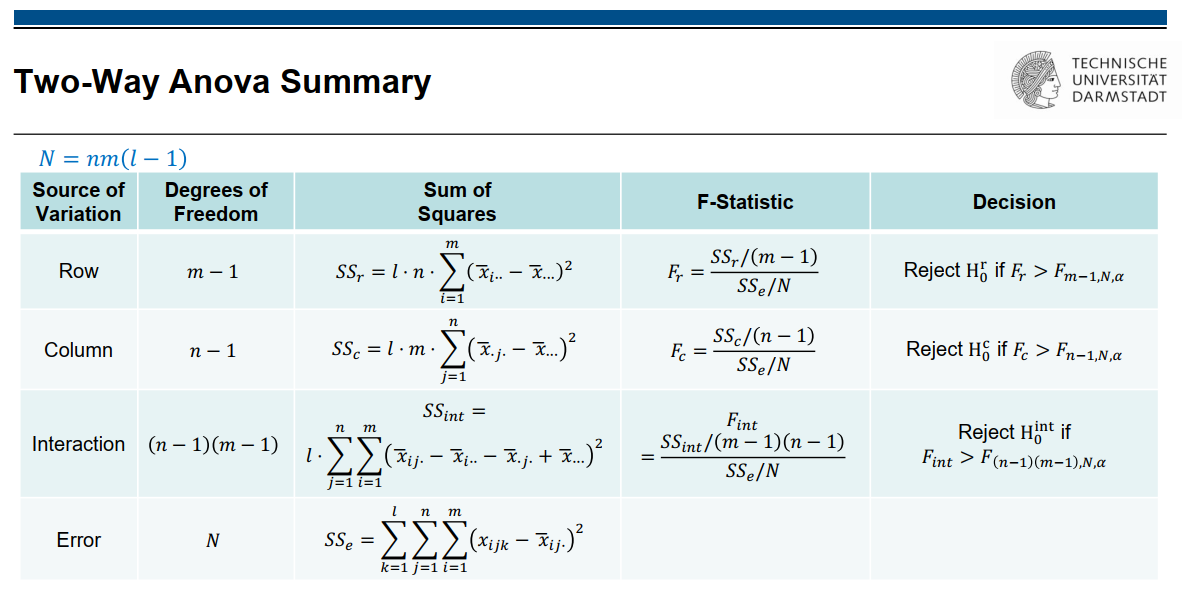